 - Extra Point:
    - Fine-tune a Transformer-based model (e.g. SwinTransformer). Compare the performance (accuracy, confusion matrix, training time, loss landscape, ...) with the one from the convolutional models.

In [40]:
from functools import partial
import os, sys
from tqdm import tqdm
from torchmetrics.classification import ConfusionMatrix
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Dataloaders and augmentations


In [41]:
image_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
        ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
])
}

data_dir = os.path.abspath(os.path.join(os.getcwd(), '..','dataset'))

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms['test'])

N_train = len(train_dataset)
N_valid = len(valid_dataset)
N_test = len(test_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")
print(f"Test set size: {N_test} images")


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Training set size: 300 images
Valdiation set size: 60 images
Test set size: 42 images


In [42]:
class_names = train_dataset.classes
print(class_names)

['human', 'robot']


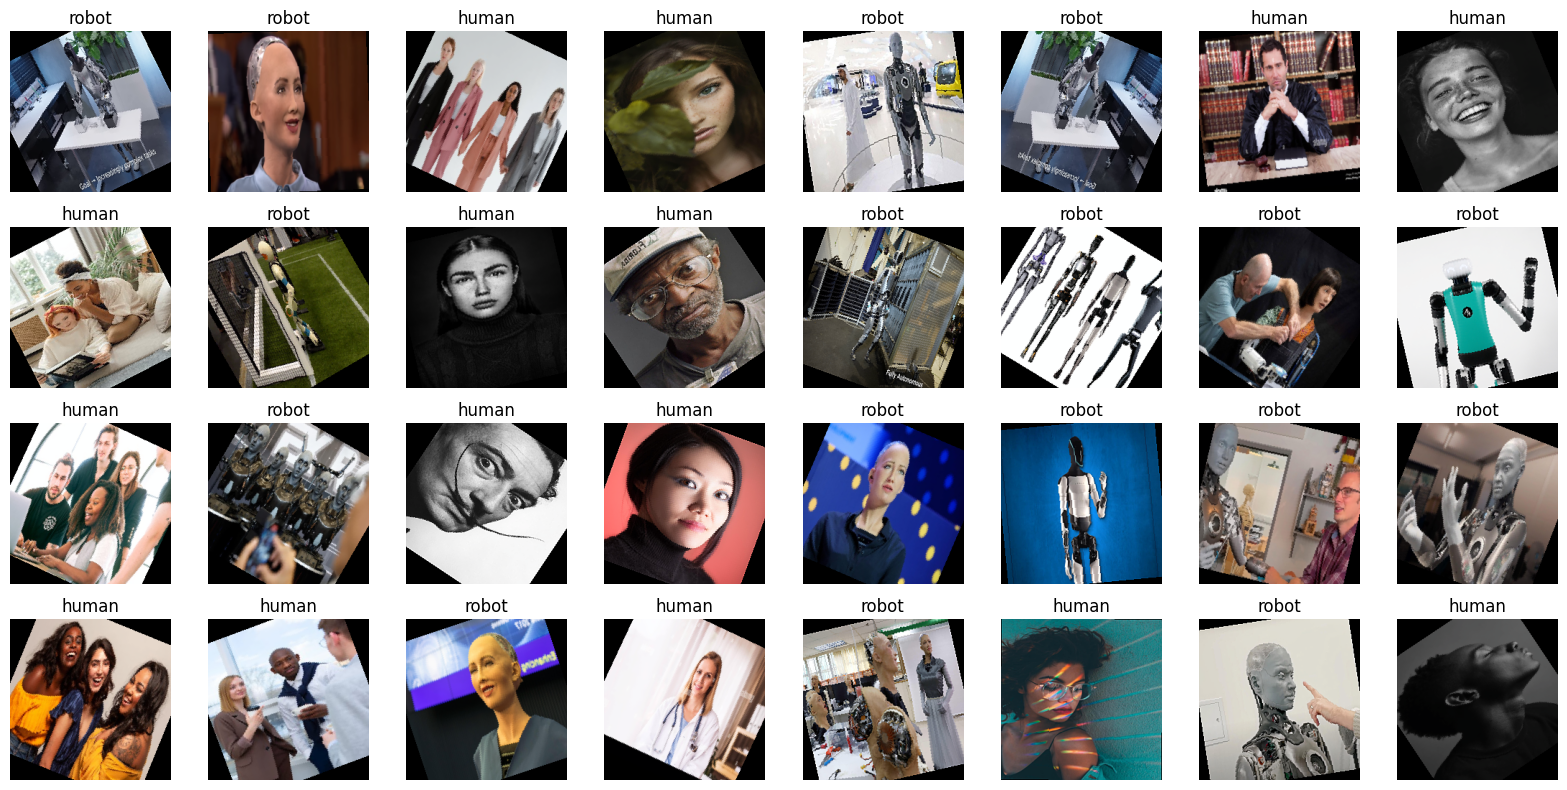

In [7]:
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

In [43]:
from torchsummary import summary

swin_t = models.swin_t(weights='DEFAULT')
summary(swin_t, input_size= (3,32,32) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           4,704
           Permute-2             [-1, 8, 8, 96]               0
         LayerNorm-3             [-1, 8, 8, 96]             192
         LayerNorm-4             [-1, 8, 8, 96]             192
ShiftedWindowAttention-5             [-1, 8, 8, 96]               0
   StochasticDepth-6             [-1, 8, 8, 96]               0
         LayerNorm-7             [-1, 8, 8, 96]             192
            Linear-8            [-1, 8, 8, 384]          37,248
              GELU-9            [-1, 8, 8, 384]               0
          Dropout-10            [-1, 8, 8, 384]               0
           Linear-11             [-1, 8, 8, 96]          36,960
          Dropout-12             [-1, 8, 8, 96]               0
  StochasticDepth-13             [-1, 8, 8, 96]               0
SwinTransformerBlock-14            

## Running evaluation before fine-tuning the model on our own dataset

In [19]:
criterion = nn.CrossEntropyLoss()

accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy before fine-tuning:" , accuracy)
print('Evaluation Loss before fine-tuning: ', loss)

Evaluation Accuracy before fine-tuning: 47.61904761904761
Evaluation Loss before fine-tuning:  0.6698590517044067


### 1. End-to-end fine tuining

In [44]:
num_logits = swin_t.head.in_features

swin_t.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)
summary(swin_t, input_size= (3,32,32) )


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           4,704
           Permute-2             [-1, 8, 8, 96]               0
         LayerNorm-3             [-1, 8, 8, 96]             192
         LayerNorm-4             [-1, 8, 8, 96]             192
ShiftedWindowAttention-5             [-1, 8, 8, 96]               0
   StochasticDepth-6             [-1, 8, 8, 96]               0
         LayerNorm-7             [-1, 8, 8, 96]             192
            Linear-8            [-1, 8, 8, 384]          37,248
              GELU-9            [-1, 8, 8, 384]               0
          Dropout-10            [-1, 8, 8, 384]               0
           Linear-11             [-1, 8, 8, 96]          36,960
          Dropout-12             [-1, 8, 8, 96]               0
  StochasticDepth-13             [-1, 8, 8, 96]               0
SwinTransformerBlock-14            

In [45]:
set_random_seed()


In [46]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(swin_t.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

In [47]:
# TODO: remove the ".." when integrated in the combined file

TBOARD_LOGS = os.path.join(os.getcwd(),"..", "tboard_logs", "Transformer", "SwinTransformer")

if os.path.exists(TBOARD_LOGS):
    shutil.rmtree(TBOARD_LOGS) # To discard old log files

os.makedirs(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

In [39]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

  0%|          | 0/15 [00:00<?, ?it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/local/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/local/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/usr/local/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/local/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._clos

Epoch 1/15
    Train loss: 0.46004
    Valid loss: 0.71202
    Accuracy: 45.0%




 33%|███▎      | 5/15 [12:55<25:25, 152.57s/it]

In [ ]:
plot(train_loss, val_loss, loss_iters, valid_acc)

### Evaluation

In [ ]:
accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy before fine-tuning:" , accuracy)
print('Evaluation Loss before fine-tuning: ', loss)

### 2. Fine-tuning with freezing backbone

In [26]:
from torchinfo import summary

swin_t = models.swin_t(weights='DEFAULT')

for param in swin_t.parameters():
    param.requires_grad = False

swin_t.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

summary(swin_t, col_names=[ "num_params",'trainable'], col_width=14) 

Layer (type:depth-idx)                             Param #        Trainable
SwinTransformer                                    --             Partial
├─Sequential: 1-1                                  --             False
│    └─Sequential: 2-1                             --             False
│    │    └─Conv2d: 3-1                            (4,704)        False
│    │    └─Permute: 3-2                           --             --
│    │    └─LayerNorm: 3-3                         (192)          False
│    └─Sequential: 2-2                             --             False
│    │    └─SwinTransformerBlock: 3-4              (112,347)      False
│    │    └─SwinTransformerBlock: 3-5              (112,347)      False
│    └─PatchMerging: 2-3                           --             False
│    │    └─Linear: 3-6                            (73,728)       False
│    │    └─LayerNorm: 3-7                         (768)          False
│    └─Sequential: 2-4                             --        

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swin_t.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

In [ ]:
plot(train_loss, val_loss, loss_iters, valid_acc)


### Evaluation

In [ ]:
accuracy, loss = eval_model(swin_t, eval_loader= test_loader, criterion= criterion, device= device)

print("Evaluation Accuracy before fine-tuning:" , accuracy)
print('Evaluation Loss before fine-tuning: ', loss)

### 3. Combined fine-tuning

In [ ]:
swin_t = models.swin_t(weights='DEFAULT')

for param in swin_t.parameters():
    param.requires_grad = False

swin_t.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=swin_t, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

# Unfreezing the network
for param in swin_t.parameters():
    param.requires_grad = True

# Reducing the lr
for param in optimizer.param_groups:
    param['lr'] *= 0.2
